## Read the data

In [758]:
import pandas as pd

df = pd.read_excel('madrid_rent_data.xlsx')

df_original = df.__deepcopy__()

## Explore the data
df.head()

,Id,District,Address,Number,Area,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
0,1,Ciudad Lineal,Piso en Quintana,NaN,Quintana,1300,2.0,72,3.0,1.0,1.0,0,0,0,0
1,2,Ciudad Lineal,Piso en calle de Arturo Soria,NaN,Costillares,3000,5.0,260,2.0,1.0,1.0,0,0,0,0
2,3,Ciudad Lineal,Piso en calle de Vicente Muzas,4,Colina,1300,2.0,100,3.0,1.0,1.0,0,0,0,0
3,4,Ciudad Lineal,Piso en calle Badajoz,NaN,San Pascual,1600,3.0,120,4.0,1.0,1.0,0,0,0,0
4,5,Ciudad Lineal,Piso en calle de Nuestra Señora del Villar,9,Ventas,800,2.0,60,3.0,1.0,0.0,0,0,0,0


## Remove uneeded columns

In [759]:
df = df.drop(columns=['Address', 'Number', 'District', 'Area'])

df.head()

,Id,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
0,1,1300,2.0,72,3.0,1.0,1.0,0,0,0,0
1,2,3000,5.0,260,2.0,1.0,1.0,0,0,0,0
2,3,1300,2.0,100,3.0,1.0,1.0,0,0,0,0
3,4,1600,3.0,120,4.0,1.0,1.0,0,0,0,0
4,5,800,2.0,60,3.0,1.0,0.0,0,0,0,0


## Get the data types

And replace null values

In [760]:
df.isnull().sum()

Id                0
Rent              0
Bedrooms         89
Sq.Mt             0
Floor           141
Outer           162
Elevator        133
Penthouse         0
Cottage           0
Duplex            0
Semidetached      0
dtype: int64

In [761]:
# df['Area'] = df['Area'].replace(0, "Unknown")
df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms'].mean())
df['Floor'] = df['Floor'].fillna(0)
df['Outer'] = df['Outer'].fillna(0.5)
df['Elevator'] = df['Elevator'].fillna(0.5)

## Separate labels and features

In [762]:
labels = df.pop('Id')
x = df

## Feature engineering

In [763]:
import numpy as np
# Add new features

x['rent_per_sqm'] = (x['Rent'] / x['Sq.Mt'])
x['rent_per_sqm'] = x['rent_per_sqm'].replace(np.inf, 0)

In [764]:
x.head()

,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached,rent_per_sqm
0,1300,2.0,72,3.0,1.0,1.0,0,0,0,0,18.055556
1,3000,5.0,260,2.0,1.0,1.0,0,0,0,0,11.538462
2,1300,2.0,100,3.0,1.0,1.0,0,0,0,0,13.000000
3,1600,3.0,120,4.0,1.0,1.0,0,0,0,0,13.333333
4,800,2.0,60,3.0,1.0,0.0,0,0,0,0,13.333333


In [765]:
# Find the categorical columns and numerical columns that we want to preprocess

categorical_columns = []
numerical_columns = ['Rent', 'Bedrooms', 'Sq.Mt', 'Floor', 'rent_per_sqm']

print(f"Categorical columns: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")

Categorical columns: []
Numerical columns: ['Rent', 'Bedrooms', 'Sq.Mt', 'Floor', 'rent_per_sqm']


In [766]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Create pipeline for categorical variables 
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# Create pipeline for numerical variables
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ('categorical', categorical_pipeline, categorical_columns),
        ('numerical', numerical_pipeline, numerical_columns)
    ], 
    remainder="passthrough"
)

In [767]:
x = preprocessor.fit_transform(x)

# turn into dataframe
x = pd.DataFrame(x)

# rename columns
x.columns = preprocessor.get_feature_names_out()

x.head()

,numerical__Rent,numerical__Bedrooms,numerical__Sq.Mt,numerical__Floor,numerical__rent_per_sqm,remainder__Outer,remainder__Elevator,remainder__Penthouse,remainder__Cottage,remainder__Duplex,remainder__Semidetached
0,-0.422876,-0.378295,-0.491885,-0.022234,0.224324,1.0,1.0,0.0,0.0,0.0,0.0
1,0.714159,1.971365,1.132764,-0.023297,-0.725230,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.422876,-0.378295,-0.249916,-0.022234,-0.512281,1.0,1.0,0.0,0.0,0.0,0.0
3,-0.222223,0.404925,-0.077081,-0.021172,-0.463713,1.0,1.0,0.0,0.0,0.0,0.0
4,-0.757298,-0.378295,-0.595586,-0.022234,-0.463713,1.0,0.0,0.0,0.0,0.0,0.0


## Show correlation betwenn features

In [768]:
def print_corr_matrix(x: pd.DataFrame):
    CORR_THRESHOLD = 0.5
    corr_matrix = x.corr()
    corr_pairs = corr_matrix.abs().unstack().reset_index()
    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    filtered_corr = corr_pairs[(corr_pairs['Variable 1'] != corr_pairs['Variable 2']) & (corr_pairs['Correlation'] > CORR_THRESHOLD)]
    sorted_corr = filtered_corr.sort_values(by='Correlation', ascending=False).drop_duplicates(subset=['Correlation'])
    sorted_corr.reset_index(drop=True, inplace=True)
    return sorted_corr

In [769]:
print_corr_matrix(x)

,Variable 1,Variable 2,Correlation
0,numerical__Rent,numerical__Sq.Mt,0.826007
1,numerical__Bedrooms,numerical__Sq.Mt,0.740397
2,numerical__Rent,numerical__Bedrooms,0.612110
3,numerical__Sq.Mt,remainder__Cottage,0.605316
4,remainder__Cottage,remainder__Semidetached,0.555805


In [770]:
# Remove variables with high correlation
x = x.drop(columns=[
    'numerical__Sq.Mt',
    'numerical__Rent',
    'numerical__Bedrooms',
    'remainder__Semidetached',
])

In [771]:
print_corr_matrix(x)

,Variable 1,Variable 2,Correlation


## Remove outliers

In [772]:
# In the outlier removal cell (around line 19), modify it to:
from sklearn.ensemble import IsolationForest

# Detect outliers using IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(x)

# Keep only non-outliers (outlier_pred == 1)
x = x[outlier_pred == 1].reset_index(drop=True)

# Also filter df_original to keep only non-outlier rows
df_original = df_original[outlier_pred == 1].reset_index(drop=True)

## Do the elbow method to find the best number of clusters

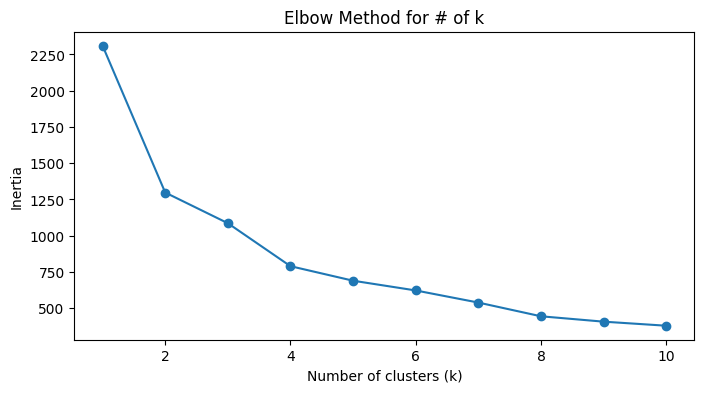

In [773]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

RANDOM_STATE = 42

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for # of k')
plt.show()

## Run K-means clustering

In [774]:
from sklearn.cluster import KMeans

N_CLUSTERS = 3  #This number might change with different data
clustering = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
clustering.fit(x)
labels = clustering.predict(x)
centroids = clustering.cluster_centers_

# Cluster labels
df_original['Cluster'] = clustering.labels_+1

df_original[["Id", "Cluster"]].sort_values("Cluster")

,Id,Cluster
0,1,1
1269,1406,1
1268,1405,1
1267,1404,1
1265,1402,1
...,...,...
299,336,3
508,577,3
297,334,3
331,372,3


## Show the cluster sizes

In [775]:
clustersizes = df_original.groupby('Cluster')['Id'].count().reset_index()
clustersizes.rename(columns={'Id': 'Count'}, inplace=True)

clustersizes

,Cluster,Count
0,1,1361
1,2,337
2,3,288


## Calculate the silhouette score and inertia

In [776]:
from sklearn.metrics import silhouette_score
import numpy as np

group_column = df_original["Cluster"]
silhouette_avg = silhouette_score(x, group_column)

# Inertia does not exist in hierarchical algoritm in scikit, so we need to calculate it
centroids = np.array([x[group_column == i].mean(axis=0) for i in range(N_CLUSTERS)])
inertia = sum(
    np.sum(np.linalg.norm(x[group_column == i] - centroids[i], axis=1)**2)
    for i in range(N_CLUSTERS)
)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Inertia: {inertia:.3f}")

Silhouette Score: 0.393
Inertia: 904.305


## Describe the clusters (WIP)

In [777]:
# Describe each cluster group by showing summary statistics for each cluster

# List of columns to describe (excluding Id and Cluster)
columns_to_describe = [col for col in df_original.columns if col not in ['Id', 'Cluster']]

# Group by cluster and describe
for cluster_num in sorted(df_original['Cluster'].unique()):
    print(f"\n=== Cluster {cluster_num} ===")
    display(df_original[df_original['Cluster'] == cluster_num][columns_to_describe].describe())

# Optionally, show the count of rows per cluster again for reference
print("\nCluster sizes:")
display(df_original['Cluster'].value_counts().sort_index())



=== Cluster 1 ===


,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
count,1361.000000,1321.000000,1361.000000,1353.000000,1339.000000,1353.0,1361.000000,1361.0,1361.000000,1361.0
mean,1805.020573,2.543528,127.494489,3.595713,0.918596,1.0,0.077149,0.0,0.021308,0.0
std,1240.792798,1.229605,86.728244,2.602962,0.273557,0.0,0.266926,0.0,0.144462,0.0
min,450.000000,0.000000,30.000000,-1.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0
25%,1000.000000,2.000000,72.000000,2.000000,1.000000,1.0,0.000000,0.0,0.000000,0.0
50%,1380.000000,2.000000,100.000000,3.000000,1.000000,1.0,0.000000,0.0,0.000000,0.0
75%,2300.000000,3.000000,154.000000,5.000000,1.000000,1.0,0.000000,0.0,0.000000,0.0
max,15000.000000,8.000000,1250.000000,23.000000,1.000000,1.0,1.000000,0.0,1.000000,0.0



=== Cluster 2 ===


,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
count,337.000000,307.000000,337.000000,332.000000,330.000000,332.000000,337.000000,337.0,337.0,337.0
mean,2312.605341,1.791531,85.632047,3.620482,0.803030,0.918675,0.112760,0.0,0.0,0.0
std,1585.048706,0.853018,54.322734,2.743121,0.398313,0.273747,0.316769,0.0,0.0,0.0
min,550.000000,0.000000,20.000000,-0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1300.000000,1.000000,50.000000,2.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0
50%,2000.000000,2.000000,72.000000,3.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0
75%,2800.000000,2.000000,105.000000,5.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0
max,16000.000000,5.000000,400.000000,17.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0



=== Cluster 3 ===


,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
count,288.000000,274.000000,288.000000,176.000000,176.000000,187.00000,288.0,288.000000,288.0,288.000000
mean,1859.614583,2.930657,173.010417,1.795455,0.687500,0.02139,0.0,0.239583,0.0,0.069444
std,2081.389895,1.648267,212.979862,1.374537,0.464835,0.14507,0.0,0.427572,0.0,0.254651
min,450.000000,0.000000,25.000000,-0.500000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
25%,690.000000,2.000000,56.000000,1.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
50%,850.000000,2.500000,70.000000,2.000000,1.000000,0.00000,0.0,0.000000,0.0,0.000000
75%,2316.250000,4.000000,203.000000,3.000000,1.000000,0.00000,0.0,0.000000,0.0,0.000000
max,12000.000000,8.000000,1230.000000,6.000000,1.000000,1.00000,0.0,1.000000,0.0,1.000000



Cluster sizes:


Cluster
1    1361
2     337
3     288
Name: count, dtype: int64